In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

from medmnist import DermaMNIST
from medmnist.info import INFO

from torch.utils.data import DataLoader
from tqdm import tqdm

In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8

In [35]:
dermaMnist_dataset = DermaMNIST(split="train", download=True, as_rgb=True, size=64)

melanoma_samples = []
np.random.seed(seed=42)
for i, sample in enumerate(dermaMnist_dataset):
    if sample[1][0] == 4:
        img_rgba = sample[0].convert("RGBA")
        melanoma_samples.append(np.array(img_rgba, dtype=np.float32) / 255)
print(f"dataset length {len(melanoma_samples)}")

np.random.shuffle(melanoma_samples)
target_img = melanoma_samples

# plt.figure(figsize=(4,4))
# plt.imshow(target_img)
# plt.show()


p = 0
pad_target = np.pad(target_img, [(0,0), (p, p), (p, p), (0, 0)])
h, w = pad_target.shape[1:3]
# pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32)).to(device)

train_dataloader = DataLoader(pad_target, batch_size=BATCH_SIZE, shuffle=False)

Using downloaded and verified file: C:\Users\Niclas\.medmnist\dermamnist_64.npz
dataset length 779


In [36]:
class Encoder(nn.Module):
    def __init__(self, input_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 2, 1)
        self.fc1 = nn.Linear(64 * 16 * 16, latent_dim)  # Changed from 64 * 8 * 8 to 64 * 16 * 16
        self.fc2 = nn.Linear(64 * 16 * 16, latent_dim)  # Changed from 64 * 8 * 8 to 64 * 16 * 16
        
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Change shape from (batch_size, height, width, channels) to (batch_size, channels, height, width)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.reshape(x.size(0), -1)  # Use reshape instead of view
        mean = self.fc1(x)
        log_var = self.fc2(x)
        return mean, log_var

# Reparameterization Trick
def reparameterize(mean, log_var):
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    return mean + eps * std

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_channels):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 64 * 16 * 16)
        self.conv1 = nn.ConvTranspose2d(64, 32, 4, 2, 1)
        self.conv2 = nn.ConvTranspose2d(32, output_channels, 4, 2, 1)
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), 64, 16, 16)
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x))
        return x

# Define the NCA Model (same as before, can add more complexity if needed)
class CAModel(nn.Module):
    def __init__(self, channel_n, fire_rate, device, hidden_size=128):
        super(CAModel, self).__init__()

        self.device = device
        self.channel_n = channel_n

        self.fc0 = nn.Linear(channel_n*3, hidden_size)
        self.fc1 = nn.Linear(hidden_size, channel_n, bias=False)
        with torch.no_grad():
            self.fc1.weight.zero_()

        self.fire_rate = fire_rate
        self.to(self.device)

    def alive(self, x):
        return F.max_pool2d(x[:, 3:4, :, :], kernel_size=3, stride=1, padding=1) > 0.1

    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            conv_weights = torch.from_numpy(weight.astype(np.float32)).to(self.device)
            conv_weights = conv_weights.view(1,1,3,3).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, conv_weights, padding=1, groups=self.channel_n)

        dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0  # Sobel filter
        dy = dx.T
        c = np.cos(angle*np.pi/180)
        s = np.sin(angle*np.pi/180)
        w1 = c*dx-s*dy
        w2 = s*dx+c*dy

        y1 = _perceive_with(x, w1)
        y2 = _perceive_with(x, w2)
        y = torch.cat((x,y1,y2),1)
        return y

    def update(self, x, fire_rate, angle):
        x = x.transpose(1,3)
        pre_life_mask = self.alive(x)

        dx = self.perceive(x, angle)
        dx = dx.transpose(1,3)
        dx = self.fc0(dx)
        dx = F.relu(dx)
        dx = self.fc1(dx)

        if fire_rate is None:
            fire_rate=self.fire_rate
        stochastic = torch.rand([dx.size(0),dx.size(1),dx.size(2),1])>fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic

        x = x+dx.transpose(1,3)

        post_life_mask = self.alive(x)
        life_mask = (pre_life_mask & post_life_mask).float()
        x = x * life_mask
        return x.transpose(1,3)

    def forward(self, x, steps=1, fire_rate=None, angle=0.0):
        for step in range(steps):
            x = self.update(x, fire_rate, angle)
        return x

# VAE-NCA Combined Model
class VAE_NCA(nn.Module):
    def __init__(self, input_channels, latent_dim, nca_channels, fire_rate, device):
        super(VAE_NCA, self).__init__()
        self.encoder = Encoder(input_channels, latent_dim).to(device)
        self.decoder = Decoder(latent_dim, input_channels).to(device)
        self.nca = CAModel(nca_channels, fire_rate, device).to(device)

    def forward(self, x, nca_steps=1):
        mean, log_var = self.encoder(x)
        z = reparameterize(mean, log_var)
        x_reconstructed = self.decoder(z)
        x_reconstructed = torch.cat((x_reconstructed, torch.ones((x_reconstructed.shape[0], 12, 64, 64)).to(device)), dim=1).permute(0, 2, 3, 1)
        x_nca = self.nca(x_reconstructed, steps=nca_steps)
        
        return x_nca, x_reconstructed, mean, log_var


In [39]:
# Loss Function
def loss_function(x_nca, x, x_reconstructed, mean, log_var):
    recon_loss = F.mse_loss(x_reconstructed, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    nca_loss = F.mse_loss(x_nca, x, reduction='sum')
    return recon_loss + kl_div + nca_loss

# Example Usage
input_channels = 4
latent_dim = 128
nca_channels = 16
fire_rate = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vae_nca = VAE_NCA(input_channels, latent_dim, nca_channels, fire_rate, device)
optimizer = optim.Adam(vae_nca.parameters(), lr=1e-3)

# Training Loop
n_epochs = 1000
for epoch in range(n_epochs):
    for x in train_dataloader:  # Assuming train_dataloader is defined
        x = x.to(device)
        optimizer.zero_grad()

        x_nca, x_reconstructed, mean, log_var = vae_nca(x, nca_steps=20)
        loss = loss_function(x_nca[..., :4], x, x_reconstructed[..., :4], mean, log_var)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {loss.item()}')

    if epoch % 50 == 0:
        torch.save(vae_nca.state_dict(), f"vae_model_{epoch}.pth")

KeyboardInterrupt: 

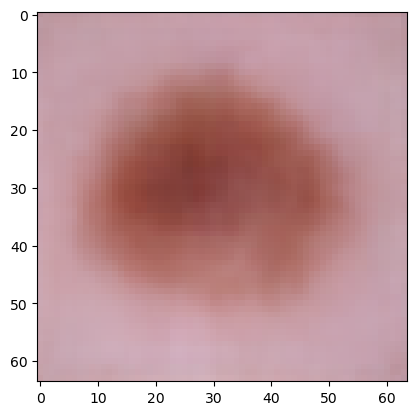

In [68]:
device = "cpu"

model = VAE_NCA(input_channels, latent_dim, nca_channels, fire_rate, device).to(device)
model.load_state_dict(torch.load("vae_model_300.pth", map_location=device))

z = ((torch.rand((8, 128)) * 2) - 1).to(device)
x_reconstructed = model.decoder(z)
x_reconstructed = torch.cat((x_reconstructed, torch.ones((x_reconstructed.shape[0], 12, 64, 64)).to(device)), dim=1).permute(0, 2, 3, 1)
x_nca = model.nca(x_reconstructed, steps=20)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Adjust figsize for better visualization

imgs = x_nca[..., :3].detach()

for i in range(2):
    for j in range(4):
        axes[i, j].imshow(x_nca[i, j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title(f"Image {i * grid_w + j + 1}")